### FRAUD DETECTION IN FINANTIAL TRANSACTIONS USING ANOMALY DETECTION WITH AUTOENCODER NETWORKS AND RANDOM FOREST MODEL BY CAIO QUINAMO

#### IMPORT NECESSARY LIBRARIES

In [3]:
import pandas as pd
import numpy as np

from IPython.display import HTML, display
from scipy import stats, spatial

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import pipeline
from sklearn import feature_selection
from sklearn import ensemble
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras

import warnings
import random

np.random.seed(4)
sns.set_style('dark')
warnings.simplefilter(action='ignore', category=FutureWarning)

#### ABOUT DATA

In [5]:
rawdata = pd.read_csv('Dataset NDSPP.2025.0001.01.1.csv')
data = rawdata.copy(deep=False)
data0, data1 = data[data['Class'] == 0], data[data['Class'] == 1]

In [6]:
# General Info
display(HTML("<h3 style=font-weight:bold; '>Data Info</h3>"))
print(data.info(verbose=False))

display(HTML("<h3 style=font-weight:bold; '>Duplicated Records</h3>"), data.duplicated().sum())
display(HTML("<h4 style=font-weight:bold; '>Data 0. Duplicated Records</h4>"), data0.duplicated().sum())

if data0.duplicated().sum() == 0:
    display(HTML("<h5 style=font-weight:bold; '>No duplicated records found</h5>"))
else:
    data0 = data0.drop_duplicates().reset_index(drop=True)
    display(HTML("<h5 style=font-weight:bold; '>Duplicated records removed successfully</h5>"))
display(HTML("<h4 style=font-weight:bold; '>Data 1. Duplicated Records</h4>"), data1.duplicated().sum())
display(HTML("<h5 style=font-weight:bold; '>Duplicated records will not be removed</h5>"))

display(HTML("<h3 style=font-weight:bold; '>Missing Values</h3>"))
nullcolumns = data.isnull().sum()[data.isnull().sum() > 0]
if nullcolumns.empty:
    display(HTML("<h5 style=font-weight:bold; '>No missing values were found</h5>"))
else:
    display(HTML("<h5 style=font-weight:bold; '>Missing values found in the following columns:</h5>"))
    print(nullcolumns)

data0 = data0.reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Columns: 31 entries, Time to Class
dtypes: float64(30), int64(1)
memory usage: 67.4 MB
None


1081

1062

19

#### AUTOENCODER NETWORK

In [8]:
mms = preprocessing.MinMaxScaler(feature_range=(0, 1))
qtt = preprocessing.QuantileTransformer(output_distribution='normal', random_state=4)

data0, data1 = data0.drop('Time', axis=1), data1.drop('Time', axis=1)
skewcolumns = np.abs(data.drop(columns=['Class']).skew()).to_frame()[np.abs(data.drop(columns=['Class']).skew()).to_frame()[0] >= 1.0].index

X0, y0 = data0.drop(columns='Class'), data0['Class'] ## Non-Fraud
X0train, X0test, y0train, y0test =     model_selection.train_test_split(X0, y0, test_size=0.30, random_state=4)
X0test, X0val, y0test, y0val = model_selection.train_test_split(X0test, y0test, test_size=0.30, random_state=4)

X0train['Amount'], X0test['Amount'] = np.log1p(X0train['Amount']), np.log1p(X0test['Amount'])
X0train[skewcolumns], X0test[skewcolumns] = qtt.fit_transform(X0train[skewcolumns]), qtt.transform(X0test[skewcolumns])
X0train, X0test = mms.fit_transform(X0train), mms.transform(X0test)

X1, y1 = data1.drop(columns='Class'), data1['Class'] ## True Fraud
X1test, X1val, y1test, y1val = model_selection.train_test_split(X1, y1, test_size=0.30, random_state=4)

X1test['Amount'] = np.log1p(X1test['Amount'])
X1test[skewcolumns] = qtt.transform(X1test[skewcolumns])
X1test = mms.transform(X1test)

In [9]:
np.random.seed(4), random.seed(4), tf.random.set_seed(4)

inputlayer = keras.layers.Input(shape=(X0train.shape[1],))

encoded = keras.layers.Dense(128, activation='tanh')(inputlayer)
encoded = keras.layers.Dropout(0.3)(encoded)
encoded = keras.layers.Dense(64, activation='tanh')(encoded)
encoded = keras.layers.Dropout(0.3)(encoded)

decoded = keras.layers.Dense(128, activation='tanh')(encoded)
decoded = keras.layers.Dense(64, activation='tanh')(decoded)

outputlayer = keras.layers.Dense(units=X0train.shape[1], activation='relu')(decoded)

autoencoder = keras.models.Model(inputlayer, outputlayer)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X0train, X0train, epochs=25, batch_size=256, shuffle=True, validation_split=0.3, verbose=1)

Epoch 1/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0200 - val_loss: 0.0012
Epoch 2/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0023 - val_loss: 6.2413e-04
Epoch 3/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0018 - val_loss: 5.0898e-04
Epoch 4/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0017 - val_loss: 4.6264e-04
Epoch 5/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0017 - val_loss: 4.4146e-04
Epoch 6/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0016 - val_loss: 4.4540e-04
Epoch 7/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0016 - val_loss: 3.8818e-04
Epoch 8/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0016 - val_loss: 3.9315e-04
Epoch 9/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0016 - val_loss: 3.8906e-04
Epoch 10/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0015 - val_loss: 4.1211e-04
Epoch 11/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0015 - val_loss: 3.8438e-04
Epoch 12/25


#### AUTOENCODER RECONSTRUCTION & FEATURE ENGINEERING

In [11]:
Xreconstructed = autoencoder.predict(np.concatenate([X0test, X1test]))
Rerror = np.mean(np.square(np.concatenate([X0test, X1test]) - Xreconstructed), axis=1).reshape(-1,1)

Xmodel = np.concatenate([Xreconstructed, Rerror], axis=1)
ymodel = np.concatenate([y0test, y1test])

1870/1870 ━━━━━━━━━━━━━━━━━━━━ 1s 532us/step


In [12]:
columns = list(data.columns.drop(['Time', 'Class']))
columns.append('R. Error')
datamodel = pd.DataFrame(Xmodel, columns=columns)
datamodel['Class'] = ymodel
datamodel0, datamodel1 = datamodel[datamodel['Class'] == 0], datamodel[datamodel['Class'] == 1]

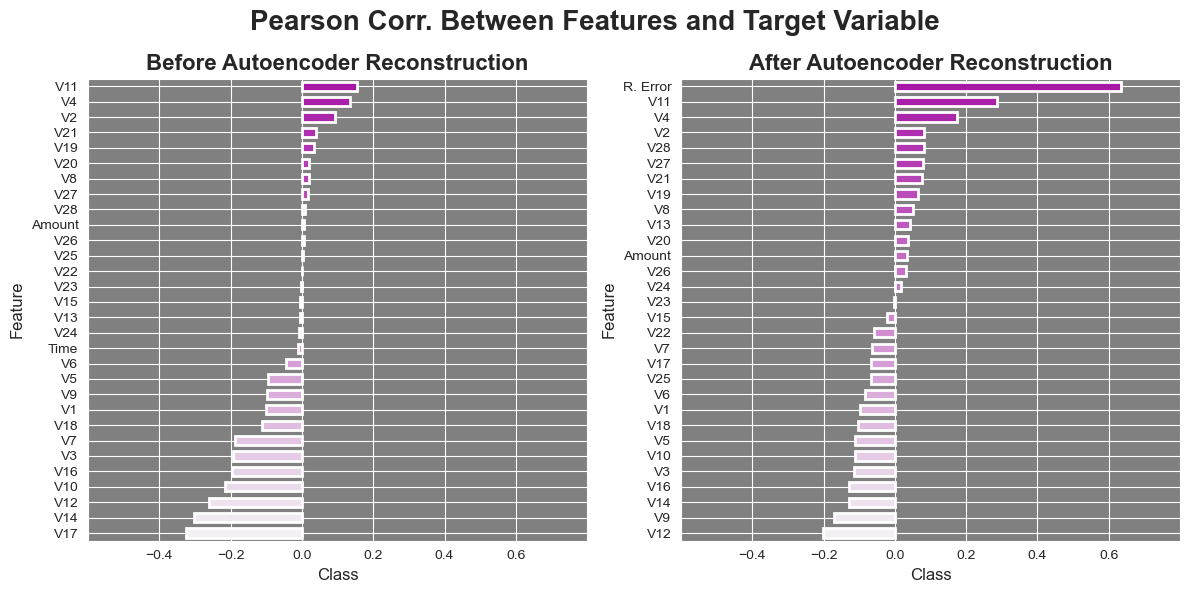

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
corr = data.corr()['Class'].drop('Class').sort_values(ascending=False).reset_index()

sns.barplot(data=corr, x='Class', y='index', width=0.6, palette='light:m_r', edgecolor='white', linewidth=2, ax=axs[0])

axs[0].set_xlabel('Class', fontsize=12), axs[0].set_ylabel('Feature', fontsize=12), axs[0].set_facecolor('grey'), axs[0].grid()
axs[0].set_xlim(-0.6, 0.8), axs[0].set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6])
axs[0].set_title('Before Autoencoder Reconstruction', size=16, weight='bold')

corr = datamodel.corr()['Class'].drop('Class').sort_values(ascending=False).reset_index()

sns.barplot(data=corr, x='Class', y='index', width=0.6, palette='light:m_r', edgecolor='white', linewidth=2, ax=axs[1])

axs[1].set_xlabel('Class', fontsize=12), axs[1].set_ylabel('Feature', fontsize=12), axs[1].set_facecolor('grey'), axs[1].grid()
axs[1].set_title('After Autoencoder Reconstruction', size=16, weight='bold')
axs[1].set_xlim(-0.6, 0.8), axs[1].set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6])
plt.suptitle('Pearson Corr. Between Features and Target Variable', size=20, weight='bold')
plt.tight_layout();

##### 1. 2-D DATA VISUALISATION (AFTER PREPROCESSING AND AUTOENCODER RECONSTRUCTION)

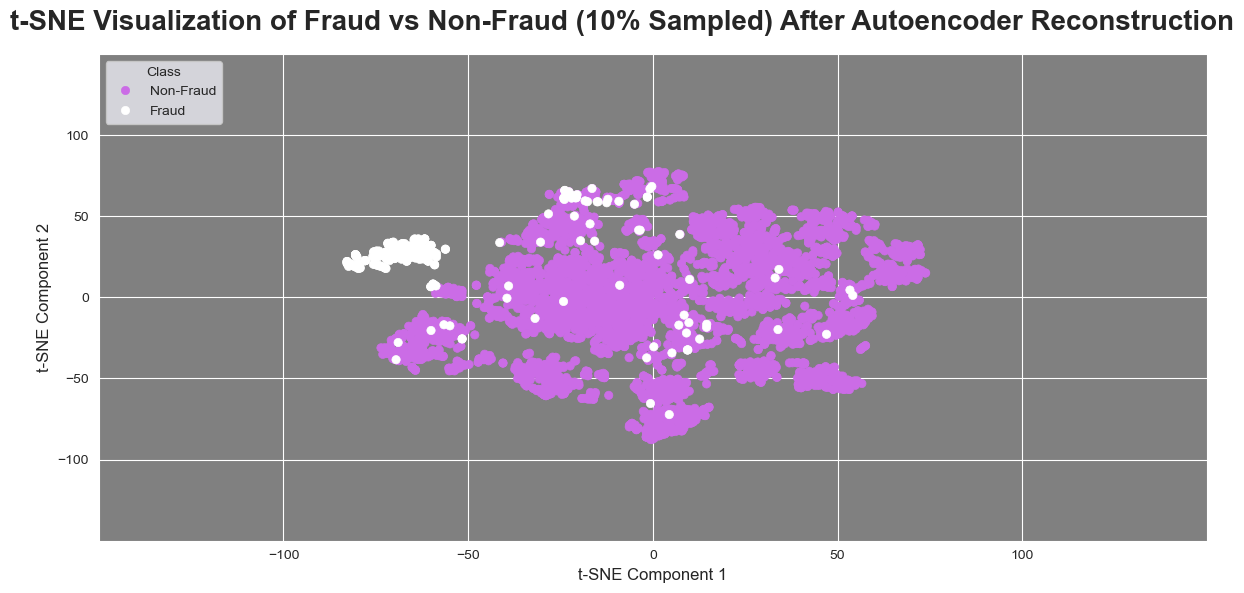

In [15]:
np.random.seed(4)
tsne = manifold.TSNE(n_components=2, random_state=4, n_jobs=-1)
fig, ax = plt.subplots(figsize=(12, 6))

plotdata0 = datamodel0.iloc[np.random.choice(datamodel0.shape[0], int(len(datamodel0) * 0.10), replace=False)]
plotdata = pd.concat([plotdata0, datamodel1], axis=0).reset_index(drop=True)
Xsampled, ysampled = plotdata.drop(['Class'], axis=1).values, plotdata["Class"].values

tsneafter = tsne.fit_transform(Xsampled)
xtsneafter, ytsneafter = tsneafter[:,0], tsneafter[:,1]
hue = pd.Series(ysampled).replace({0:'Non-Fraud', 1:'Fraud'})

sns.scatterplot(x=xtsneafter, y=ytsneafter, hue=hue, palette=['#CB6CE6', 'white'], edgecolor=None)
plt.grid(), ax.set_facecolor('grey'), plt.legend(title='Class', loc='upper left')
plt.xlim(-150, 150), plt.xticks([-100, -50, 0, 50, 100]), plt.ylim(-150, 150), plt.yticks([-100, -50, 0, 50, 100])
plt.xlabel('t-SNE Component 1', fontsize=12), plt.ylabel('t-SNE Component 2', fontsize=12)
plt.suptitle('t-SNE Visualization of Fraud vs Non-Fraud (10% Sampled) After Autoencoder Reconstruction',
             fontsize=20, fontweight='bold'), plt.tight_layout();

### MODEL OPTIMISATION

In [30]:
kbest = 22
rfc = pipeline.Pipeline([('kbest', feature_selection.SelectKBest(score_func=feature_selection.mutual_info_classif, k=kbest)),
                          ('clf', ensemble.RandomForestClassifier(class_weight='balanced', min_samples_split=10, 
                                                                  n_estimators=300, n_jobs=-1, random_state=4))])

In [34]:
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np
yprob_cv = model_selection.cross_val_predict(rfc, Xmodel, ymodel, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
# yprob_cv: probabilidades, ymodel: etiquetas verdaderas
prec, rec, thresholds = precision_recall_curve(ymodel, yprob_cv)
f1s = 2 * (prec * rec) / (prec + rec + 1e-8)

best_idx = np.argmax(f1s)
best_thresh = thresholds[best_idx]
best_f1 = f1s[best_idx]

print(f"Mejor umbral = {best_thresh:.4f}, F1-score = {best_f1:.4f}")

Mejor umbral = 0.2693, F1-score = 0.8790


In [35]:
display(rfc.fit(Xmodel, ymodel))

Pipeline(steps=[('kbest',
                 SelectKBest(k=22,
                             score_func=<function mutual_info_classif at 0x000001F6BCFF20C0>)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        min_samples_split=10, n_estimators=300,
                                        n_jobs=-1, random_state=4))])

In [38]:
Xfinal, yfinal = pd.concat([X0val, X1val]), pd.concat([y0val, y1val]) ## CONCATENATE ONLY IN THIS CASE

Xfinal['Amount'] = np.log1p(Xfinal['Amount'])
Xfinal[skewcolumns] = qtt.transform(Xfinal[skewcolumns])
Xfinal = mms.transform(Xfinal)

Xrec = autoencoder.predict(Xfinal)
Rerror = np.mean(np.square(Xfinal - Xrec), axis=1).reshape(-1,1)

Xfinal = np.concatenate([Xrec, Rerror], axis=1)

802/802 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


In [40]:
yprob = rfc.predict_proba(Xfinal)[:, 1]
ypred = (yprob >= best_thresh).astype(int)
clsrprt = metrics.classification_report(yfinal, ypred, output_dict=True)
report = pd.DataFrame(clsrprt).transpose()
report = report.style.set_table_attributes('style="margin-left: auto; margin-right: auto;"')
display(HTML("<h3 style='font-weight:bold;' >Random Forest Classifier Metrics (Trained and Tested with Autoencoder Reconstructed Data)</h3>"))
display(report)

,precision,recall,f1-score,support
0,0.999098,0.999451,0.999274,25493.000000
1,0.899281,0.844595,0.871080,148.000000
accuracy,0.998557,0.998557,0.998557,0.998557
macro avg,0.949189,0.922023,0.935177,25641.000000
weighted avg,0.998522,0.998557,0.998535,25641.000000


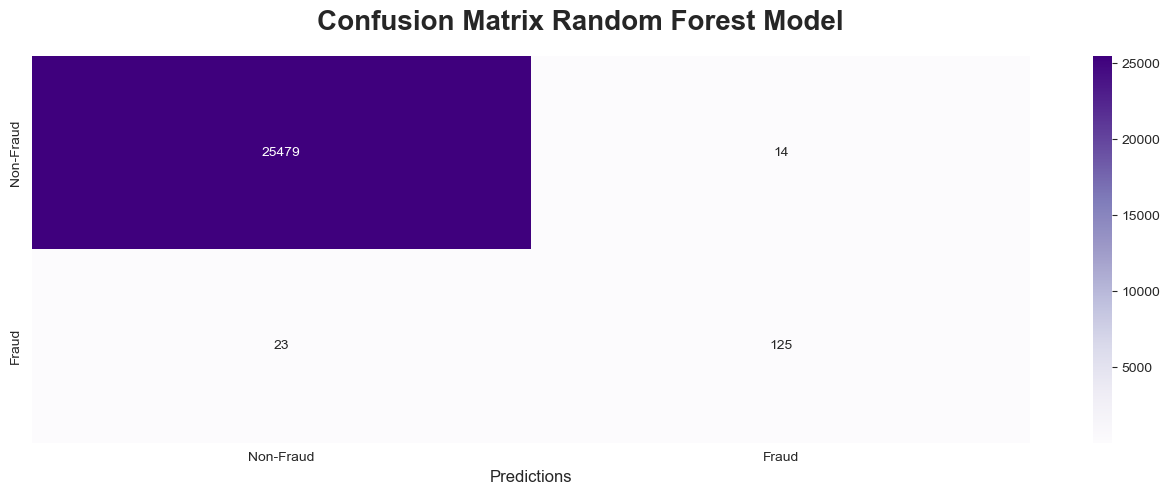

In [42]:
fig, ax = plt.subplots(figsize=(13, 5))
cm = metrics.confusion_matrix(yfinal, ypred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predictions', fontsize=12), plt.ylabel(None)
plt.suptitle('Confusion Matrix Random Forest Model', fontsize=20, fontweight='bold', x=0.45), plt.tight_layout();

In [26]:
cv = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=4)
ymodelproba = model_selection.cross_val_predict(rfc, Xmodel, ymodel, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
auprc_train = metrics.average_precision_score(ymodel, ymodelproba) ## Calcula el AUPRC global
print('TRAIN DATA')
print(f"Average AUPRC: {auprc_train:.4f}")

yfinalproba = model_selection.cross_val_predict(rfc, Xfinal, yfinal, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
auprc_score = metrics.average_precision_score(yfinal, yfinalproba) ## Calcula el AUPRC global
print('TEST DATA')
print(f"Average AUPRC: {auprc_score:.4f}")

Average AUPRC: 0.8675


(None,)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
index = datamodel.drop(columns='Class').columns[rfc.named_steps['kbest'].get_support()]
importances = pd.DataFrame(data=rfc.named_steps['clf'].feature_importances_, columns=['Feature'], index=index)
importances = importances.reset_index().sort_values(by='Feature', ascending=False).reset_index(drop=True)

sns.barplot(data=importances, x='index', y='Feature', palette='light:m_r', width=0.7)
plt.xlabel('Feature', fontsize=12), plt.ylabel('Importance', fontsize=12)
plt.suptitle('Feature Importances in Random Forest Classifier', fontsize=20, fontweight='bold')
plt.xticks(rotation=-30), plt.grid(), ax.set_facecolor('grey'), plt.tight_layout();

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
precision, recall, _ = metrics.precision_recall_curve(yfinal, yprob)
avgps = metrics.average_precision_score(yfinal, yprob)

ax.plot(recall, precision, color='#CB6CE6', linewidth=4)
str_text = f'Precision-Recall Score\nAverage = {avgps:.3f}'
ax.text(0, 0.05, str_text, fontsize=14, bbox=dict(facecolor='white', alpha=0.7, edgecolor='w', boxstyle='round,pad=1'))
ax.set_xlabel('Recall', fontsize=12), ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curve Random Forest Model', fontsize=20, fontweight='bold')
ax.set_facecolor('grey'), plt.grid(True), plt.tight_layout();

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))

fpr, tpr, _ = metrics.roc_curve(yfinal, yprob)
roc_auc = metrics.auc(fpr, tpr)

ax.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})', color='#CB6CE6', linewidth=4)
sns.lineplot(x=[0, 1], y=[0, 1], label='Random Classifier', color='white', linestyle='--')
plt.xlabel('False Positive Rate (FPR)', fontsize=12), plt.ylabel('True Posivitive Rate (TPR)', fontsize=12)
plt.suptitle('Receiver Operating Characteristic (ROC) Curve', fontsize=20, fontweight='bold')
plt.legend(loc='lower right'), ax.set_facecolor('grey'), plt.grid(), plt.tight_layout();

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
tsnedata = pd.DataFrame(tsne.fit_transform(Xfinal), columns=['t-SNE Component 1', 't-SNE Component 2'])
tsnedata['True'], tsnedata['Pred'] = yfinal.values, ypred
testtrue0, testtrue1 = tsnedata[tsnedata['True'] == 0], tsnedata[tsnedata['True'] == 1]
testpred0, testpred1 = tsnedata[tsnedata['Pred'] == 0], tsnedata[tsnedata['Pred'] == 1]

huefinal = pd.Series(yfinal).replace({0:'Non-Fraud', 1:'Fraud'})
sns.scatterplot(x=testtrue0['t-SNE Component 1'], y=testtrue0['t-SNE Component 2'], color='#CB6CE6', edgecolor=None, ax=axs[0], label='Non-Fraud')
sns.scatterplot(x=testtrue1['t-SNE Component 1'], y=testtrue1['t-SNE Component 2'], color='white', edgecolor=None, ax=axs[0], label='Fraud')
axs[0].set_title('True Labels', fontsize=16, fontweight='bold')
axs[0].set_facecolor('grey'), axs[0].grid(), axs[0].legend(title='True Class')

huepred = pd.Series(ypred).replace({0:'Non-Fraud', 1:'Fraud'})
sns.scatterplot(x=testpred0['t-SNE Component 1'], y=testpred0['t-SNE Component 2'], color='#CB6CE6', edgecolor=None, ax=axs[1], label='Non-Fraud')
sns.scatterplot(x=testpred1['t-SNE Component 1'], y=testpred1['t-SNE Component 2'], color='white', edgecolor=None, ax=axs[1], label='Fraud')
axs[1].set_title('Predicted Labels', fontsize=16, fontweight='bold')
axs[1].set_facecolor('grey'), axs[1].grid(), axs[1].legend(title='Predicted Class')

fig.suptitle('Comparison of True vs Predicted Labels on t-SNE Projection of Test Data', fontsize=20, fontweight='bold'), plt.tight_layout();